In [106]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette(sns.color_palette('mako'))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [107]:
codebook = pd.read_excel('./data/recs2020_public_codefile_v5.xlsx', sheet_name='codebook', header=1)
codebook.head()

,Variable,Type,Description and Labels,Response Codes,Section
0,DOEID,Num,Unique identifier for each respondent,100001-118496,ADMIN
1,REGIONC,Char,Census Region,Midwest\nNortheast\nSouth\nWest,GEOGRAPHY
2,DIVISION,Char,"Census Division, Mountain Division is divided ...",East North Central\nEast South Central\nMiddle...,GEOGRAPHY
3,STATE_FIPS,Char,State Federal Information Processing System Code,state_dictionary!A1,GEOGRAPHY
4,state_postal,Char,State Postal Code,state_dictionary!A1,GEOGRAPHY


In [108]:
target_cols = ['BTUEL', 'BTUNG', 'BTULP', 'BTUFO', 'BTUWD', 'TOTALBTU']
column_groups = {}

responses = pd.read_csv('./data/recs2020_public_v5.csv', na_values=['-2'])

drop_ids = ['DOEID']
drop_usage = codebook.query("`Section` == 'End-use Model' and `Variable` not in @target_cols")['Variable']
drop_extra = responses.filter(regex='^(Z|NWEIGHT)').columns

to_drop = drop_ids + drop_usage.tolist() + drop_extra.tolist()
responses.drop(to_drop, axis=1, inplace=True)

def set_column_group(group, cols):
    remaining = [col for col in cols if col in responses.columns]
    if remaining:
        column_groups[group] = remaining

for group in codebook['Section'].unique():
    set_column_group(group, codebook.query("`Section` == @group")['Variable'])

responses.head()

,REGIONC,DIVISION,STATE_FIPS,state_postal,state_name,BA_climate,IECC_climate_code,UATYP10,HDD65,CDD65,...,TOTCSQFT,BTUEL,BTUNG,BTULP,BTUFO,BTUWD,TOTALBTU,DBT1,DBT99,GWT
0,WEST,Mountain South,35,NM,New Mexico,Mixed-Dry,4B,U,3844,1679,...,2100,42723.28,101924.43,0.0,0.0,0.0,144647.71,92.9,21.6,58.5
1,SOUTH,West South Central,5,AR,Arkansas,Mixed-Humid,4A,U,3766,1458,...,590,17889.29,10145.32,0.0,0.0,0.0,28034.61,91.3,16.1,57.2
2,WEST,Mountain South,35,NM,New Mexico,Mixed-Dry,4B,U,3819,1696,...,900,8146.63,22603.08,0.0,0.0,0.0,30749.71,92.9,21.6,58.5
3,SOUTH,South Atlantic,45,SC,South Carolina,Mixed-Humid,3A,U,2614,1718,...,2100,31646.53,55118.66,0.0,0.0,0.0,86765.19,91.8,25.1,61.5
4,NORTHEAST,Middle Atlantic,34,NJ,New Jersey,Mixed-Humid,4A,U,4219,1363,...,800,20027.42,39099.51,0.0,0.0,0.0,59126.93,81.8,13.0,55.9


In [109]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(responses, test_size=0.2, random_state=42)

# use the training set for further analysis
households = train_set.copy()
print('train_set', train_set.shape)
print('test_set', test_set.shape)

train_set (14796, 310)
test_set (3700, 310)


## Target variable analysis

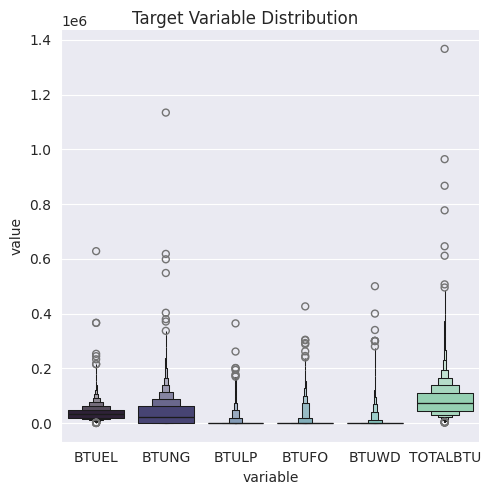

In [110]:
melted = households[target_cols].melt()
g = sns.catplot(data=melted, x='variable', y='value', hue='variable', legend=False, kind='boxen')
g.fig.suptitle('Target Variable Distribution')
plt.show()

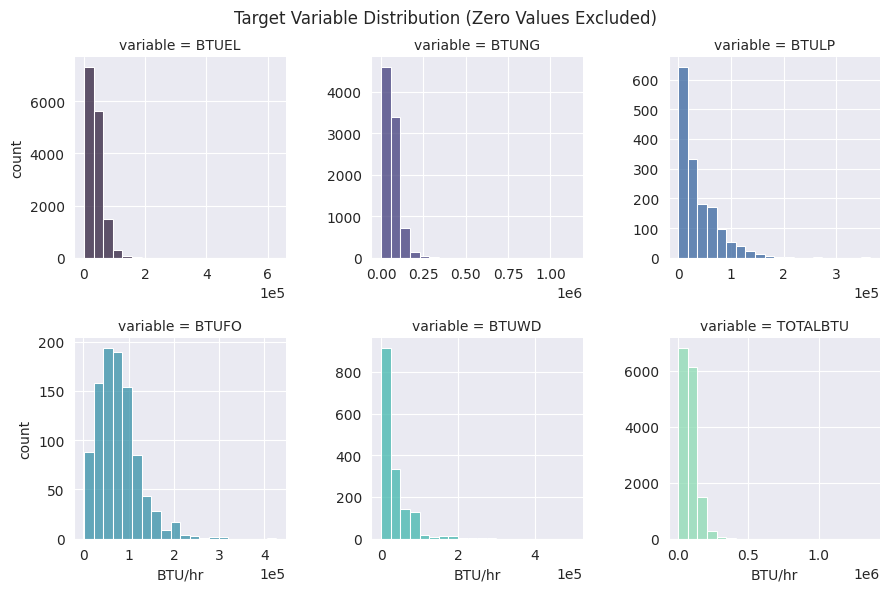

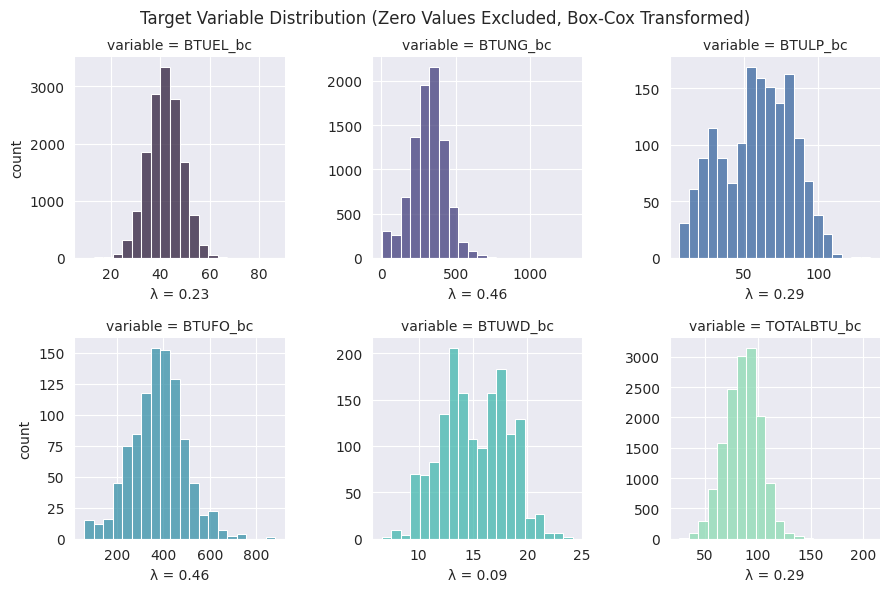

In [111]:
from scipy.stats import boxcox

def plot_hist(cols, title, xlabel=None):
    melted = households[cols].melt()
    melted = melted[melted['value'] > 0]

    g = sns.FacetGrid(melted, col='variable', hue='variable', col_wrap=3, sharex=False, sharey=False)
    g.map(sns.histplot, 'value', bins=20)
    g.set_axis_labels(xlabel, 'count')
    g.fig.suptitle(title)
    g.fig.subplots_adjust(top=0.9, hspace=0.4)
    return g

g = plot_hist(target_cols, 'Target Variable Distribution (Zero Values Excluded)', 'BTU/hr')
for ax in g.axes.flat:
    ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.show()

for col in target_cols:
    non_zero_rows = households[col] > 0
    transformed, lmda = boxcox(households.loc[non_zero_rows, col])

    households.loc[non_zero_rows, f'{col}_bc'] = transformed
    households.loc[~non_zero_rows, f'{col}_bc'] = 0
    households[f'{col}_lambda'] = [lmda] * len(households)

target_cols_transformed = [f'{col}_bc' for col in target_cols]

g = plot_hist(target_cols_transformed, 'Target Variable Distribution (Zero Values Excluded, Box-Cox Transformed)')
for (var, axes) in g.axes_dict.items():
    lmda = households[var.replace('_bc', '_lambda')].iloc[0]
    axes.set(xlabel=f'λ = {lmda:.2f}')
plt.show()

## Climate variable analysis

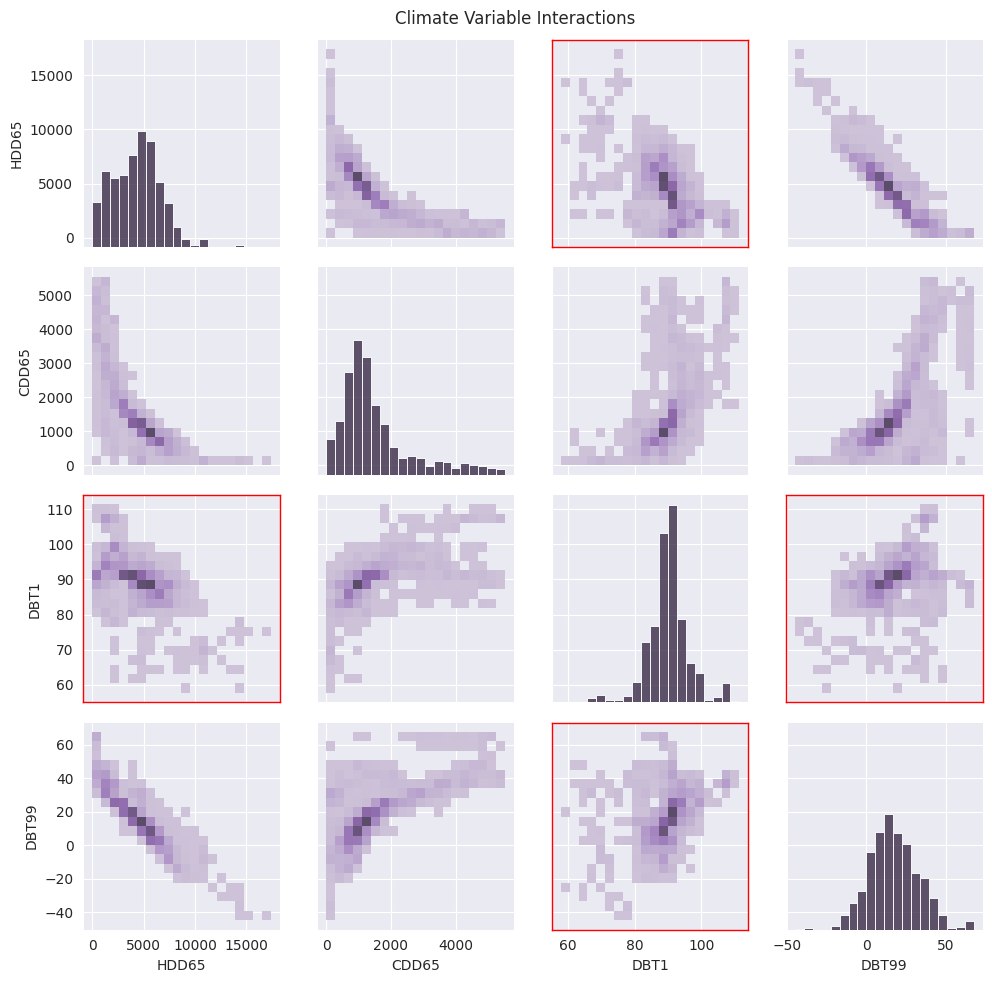

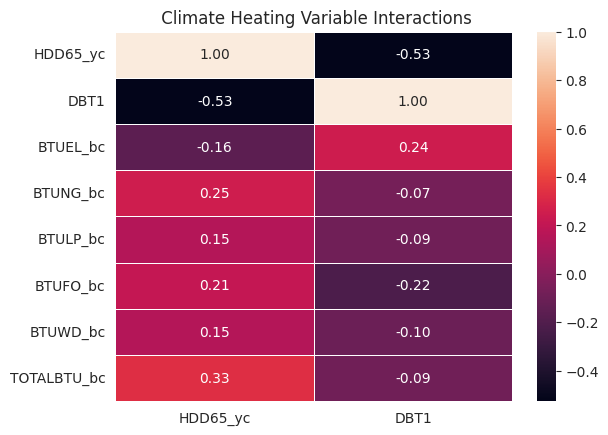

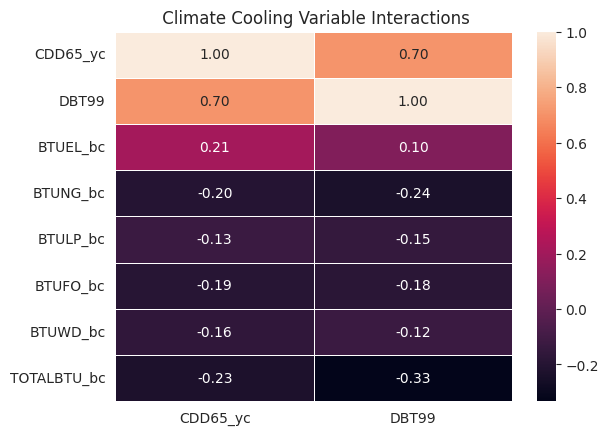

In [135]:
from scipy.stats import yeojohnson

# HDD65, CDD65, DBT1, & DBT99 can all be inferred from the open-meteo API
weather_cols = [col for col in column_groups['WEATHER'] if col not in ['HDD30YR_PUB', 'CDD30YR_PUB', 'GWT']]

# plot climate variable interactions
g = sns.PairGrid(data=households, vars=weather_cols)
g.map_diag(sns.histplot, bins=20)
g.map_offdiag(sns.histplot, bins=20)
g.fig.suptitle('Climate Variable Interactions')
g.fig.subplots_adjust(top=0.95)

# highlight that DBT1 is the only variable with visibly weak correlations to its neighbors:
for i, j in [(0, 2), (2, 0), (2, 3), (3, 2)]:
    ax = g.axes[i, j]
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('red')
        spine.set_linewidth(1)

plt.show()

# transform long-tailed degree-day variables
weather_transform_cols = ['CDD65', 'HDD65']

for col in weather_transform_cols:
    transformed, lmda = yeojohnson(households[col])
    households[f'{col}_yc'] = transformed
    households[f'{col}_lambda'] = [lmda] * len(households)

weather_cols_transformed = [f'{col}_yc' if col in weather_transform_cols else col for col in weather_cols]

def plot_weather_corr(cols, title):
    corr = households[cols + target_cols_transformed].corr()
    corr = corr[cols]

    ax = sns.heatmap(corr, annot=True, fmt='.2f', linewidth=0.5, )
    ax.set_title(title)
    plt.show()

# plot heating climate features against targets
# note that heating design temperature is less correlated with heating degree days, and each interacts differently with targets
plot_weather_corr(['HDD65_yc', 'DBT1'],' Climate Heating Variable Interactions')

# plot cooling climate features against targets
# note that cooling design temperature is highly correlated with cooling degree days, and each have similar interactions with targets
plot_weather_corr(['CDD65_yc', 'DBT99'],' Climate Cooling Variable Interactions')

## Home variable analysis

## Appliance variable analysis

## HVAC variable analysis

## Household variable analysis